<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
Here we are going to work on the model to extract Car type/model/accessories from article/post.

In [1]:
import os
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 1
TEST_SIZE = 0.2

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Data Set**](#sect1)</font>
* <font size='3ptx'>[**Word2vec Solution**](#sect2)</font>
* <font size='3ptx'>[**ML Models**](#sect3)</font>

## <font color='darkblue'>Data Set</font> ([back](#sect0))
We collect and label our data from dumped data [here](https://drive.google.com/file/d/1LTyPKtafRQnQp-DslpjBM5QUWoxAtSTY/view?usp=sharing). Let's load labelling data back for future process:

In [165]:
df = pd.read_csv("datas.csv")
df.head()

,kw,sentence
0,Tesla Model 3,"The Tesla\_h Model\_h 3\_h is an American four-door saloon car with rear- or -four-wheel drive, seating for five people at a pinch, and a touchscreen inside."
1,Tesla Model 3,We think right now may be the best time to buy a Tesla\_h Model\_h 3\_h.
2,BMW 228 Gran Coupe,The BMW\_h 228\_h Gran\_h Coupe\_h is a sedan.
3,228 Gran Coupe,"The 2021 228\_h Gran\_h Coupe\_h starts at $35,700 (MSRP), with a destination charge of $995."
4,Toyota Avalon,The Toyota\_h Avalon\_h is a sedan.


In [166]:
word_set = set()
label_c = label_a = label_o = 0
for ri, r in df.iterrows():
    words = r.sentence.split()
    for i in range(len(words)):                
        if words[i][-1] in ",.!?":
            words[i] = words[i][:-1]
        elif words[i][-2:] == "'s":
            words[i] = words[i][:-2]
            
        if words[i].startswith('('):
            words[i] = words[i][1:]
            
        if words[i].endswith(')'):
            words[i] = words[i][:-1]
            
    new_words = []
    for w in words:
        if w.endswith('\_h'):
            w = w[:-3]
            word_set.add(w)
            w = f"{color.BOLD}{color.BLUE}{w}{color.END}"
            label_c += 1
            
        elif w.endswith('\_a'):
            w = w[:-3]
            word_set.add(w)
            w = f"{color.BOLD}{color.RED}{w}{color.END}"
            label_a += 1
        else:
            label_o += 1
            
        new_words.append(w)        
    print(" ".join(new_words))

The Tesla Model 3 is an American four-door saloon car with rear- or -four-wheel drive seating for five people at a pinch and a touchscreen inside
We think right now may be the best time to buy a Tesla Model 3
The BMW 228 Gran Coupe is a sedan
The 2021 228 Gran Coupe starts at $35,700 MSRP with a destination charge of $995
The Toyota Avalon is a sedan
The Toyota Avalon is a full-size car produced by Toyota
The BMW 327 is a medium-sized touring coupé produced by the Bavarian firm between 1937 and 1941
In the shark nose of the Ferrari 812 GTS is a 6.5-litre V12 engine free of turbos and able to rev to almost 9,000rpm as a result
Equip your Ferrari 812 with the Novitec Aero Kit
I just bought at 2015 Ford focus back at the end of September and have been enjoying it up until a week ago when the Bluetooth stopped pairing and would just say disconnected
2015 Ford Focus bluetooth SYNC issue
On the racetrack the sound of the of the Porsche 911 GT3 exhaust sys- tem is unmistakable
Porsche 911 Blu

In [167]:
print(f"Total {label_o:,d} O label(s); {label_c:,d} C label(s) and {label_a:,d} A label(s)")

Total 2,651 O label(s); 208 C label(s) and 108 A label(s)


We store a list of car brands for future reference and process in file `car_brand_list.txt`.

In [153]:
car_brand_set = set()
with open('car_brand_list.txt', 'r') as fo:
    for line in fo:
        line = line.lower()
        car_brand_set.add(tuple(list(map(lambda w: w.lower(), line.split()))))
    
list(car_brand_set)[:10]

[('peugeot',),
 ('kamaz',),
 ('geely',),
 ('derways',),
 ('chevrolet',),
 ('subaru',),
 ('land', 'rover'),
 ('mg',),
 ('lancia',),
 ('nissan',)]

We also keep many post to hold content without desired entity which can be used for training in directory `negative_posts`:

In [6]:
NEGATIVE_DIR_PATH = 'negative_posts'

<a id='sect2'></a>
## <font color='darkblue'>Word2vec Solution</font> ([back](#sect0))
* [**Fasttext**](#sect2_1)
* [**Gensim**](#sect2_2)

[**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a technique for [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing). The word2vec algorithm uses a neural network model to learn word associations from a large [corpus of text](https://en.wikipedia.org/wiki/Corpus_of_text). Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.
![1.png](images/1.png)
<br/>

<a id='sect2_1'></a>
### <font color='darkgreen'>Fasttext - Word to vector</font>
Here we will leverage [**Fasttext**](https://github.com/facebookresearch/fastText) package to help us to translate word into vector for later ML training. Instead of re-training a new Fasttext model, we will use exist trained model [here](https://fasttext.cc/docs/en/crawl-vectors.html) [cc.en.300.bin.gz](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz). Please click the link and download it:

In [7]:
#!pip install fasttext

In [8]:
#import fasttext.util

#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

After that, below code will load the downloaded model:

In [9]:
#import fasttext
#import fasttext.util

<a id='sect2_2'></a>
### <font color='darkgreen'>Gensim - Word to vector</font>
Here we will leverage [**Gensim**](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) to help us to translate word into vector for later ML training.

In [10]:
# Load in word vector translator
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
unknown_word_set = set()
for w in word_set:
    try:
        wv[w]
    except:
        unknown_word_set.add(w)
        
print(f"Total {len(unknown_word_set)} unknown word(s) found!")
print(unknown_word_set)

Total 32 unknown word(s) found!
{'20d', '2011', '2018', 'Roav', 'Q50', '2017', '228', 'WF-1000xm3', '2021', 'jvc', 'entune', '2013', '2002', "Civic's", "VW's", '327', '228i', "Toyota's", '812', 'Q60', '911', '2020', 'HR-V', '2014', 'R-link', 'cr-v', 'Crosstrek', '780', 'BT-Splitter', 'HondaLink', '2019', '2015'}


<a id='sect3'></a>
## <font color='darkblue'>ML Models</font>
Here we are going to explore some ML solutions to deal with NER problem.

### <font color='darkgreen'>CRF </font>
Pleae refer to this [notebook](https://nbviewer.jupyter.org/github/johnklee/ml_articles/blob/master/medium/NLP_Guide_Identifying_Part_of_Speech_Tags_using_Conditional_Random_Fields/notebook.ipynb) for more details.

In [12]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import nltk
#nltk.download("punkt")

In [13]:
def is_car_brand(sentence, index):
    for car_brand in car_brand_set:
        if ' '.join(car_brand) == ' '.join(list(map(lambda w: w.lower(), sentence[index:index+len(car_brand)]))):
            return 1
        
    return 0

def crf_features(sentence, index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    return {
        'is_car_brand': is_car_brand(sentence, index),
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'prev_2word':'' if index<=1 else ''.join(sentence[index-2:index]),
        'next_word':'' if index<=len(sentence)-1 else sentence[index+1],
        'next_2word':'' if index<=len(sentence)-2 else sentence[index+1:index+2],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
    }

In [114]:
# See if a word combination is treated a car brand or not
is_car_brand(['bmw'], 0)

1

In [115]:
# See how a sentence is translated into CRF feature vector
for ri, r in df.iterrows():
    if '\_a' in r.sentence and '\_h' in r.sentence:
        print(r.sentence)
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
          
        print(f"words: {words}\nlabels: {tags}\n")
        feat_4word = [crf_features(words, i) for i in range(len(words))][3]        
        print(json.dumps(feat_4word, sort_keys=True, indent=4))
        # y.append(tags)
        break

Mine is a Nissan\_h Frontier\_h with an aftermarket Kenwood\_a touchscreen\_a radio\_a by the way.
words: ['Mine', 'is', 'a', 'Nissan', 'Frontier', 'with', 'an', 'aftermarket', 'Kenwood', 'touchscreen', 'radio', 'by', 'the', 'way', '.']
labels: ['o', 'o', 'o', 'c', 'c', 'o', 'o', 'o', 'a', 'a', 'a', 'o', 'o', 'o', 'o']

{
    "is_alphanumeric": 0,
    "is_car_brand": 1,
    "is_complete_capital": 0,
    "is_first_capital": 1,
    "is_first_word": 0,
    "is_last_word": 0,
    "is_numeric": 0,
    "next_2word": "",
    "next_word": "",
    "prefix_1": "N",
    "prefix_2": "Ni",
    "prefix_3": "Nis",
    "prefix_4": "Niss",
    "prev_2word": "isa",
    "prev_word": "a",
    "suffix_1": "n",
    "suffix_2": "an",
    "suffix_3": "san",
    "suffix_4": "ssan",
    "word_has_hyphen": 0
}


In [16]:
def get_crf_data():    
    X, y = [], []
    for ri, r in df.iterrows():
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
            
        X.append([crf_features(words, i) for i in range(len(words))])
        y.append(tags)
        
    for f in os.listdir(NEGATIVE_DIR_PATH):
        fp = os.path.join(NEGATIVE_DIR_PATH, f)
        with open(fp, 'r', encoding='utf8') as fo:
            for i in range(4):
                fo.readline()  # Skip URL and title
                
            post_content = fo.read()
            sentences = list(filter(lambda s: s, map(lambda s: s.strip(), nltk.sent_tokenize(post_content))))
            for sent in sentences:
                tokens = nltk.tokenize.word_tokenize(sent)
                X.append([crf_features(tokens, i) for i in range(len(tokens))])
                y.append(['o'] * len(tokens))
                    
    return X, y

In [17]:
# https://ithelp.ithome.com.tw/articles/10222958
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10,6))  #調整圖的大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [168]:
X, y = get_crf_data()
print(f"We total have {len(X):,d} records for training!")

We total have 659 records for training!


In [169]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X, y)

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.01, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [170]:
y_pred=crf.predict(X)
print("F1 score on Test Data ")
print(f"{metrics.flat_f1_score(y, y_pred,average='weighted', labels=crf.classes_):.05f}")

### Look at class wise score
print(metrics.flat_classification_report(
    y, y_pred, labels=crf.classes_, digits=3
))

F1 score on Test Data 
0.99989
              precision    recall  f1-score   support

           o      1.000     1.000     1.000     17322
           c      0.995     1.000     0.998       208
           a      0.991     1.000     0.995       108

    accuracy                          1.000     17638
   macro avg      0.995     1.000     0.998     17638
weighted avg      1.000     1.000     1.000     17638



In [21]:
print("Number of Transition Features ")
len(crf.transition_features_)

Number of Transition Features 


9

In [22]:
Counter(crf.transition_features_).most_common(20)

[(('o', 'o'), 2.593967),
 (('a', 'a'), 2.589403),
 (('c', 'c'), 2.304625),
 (('c', 'o'), -1.051883),
 (('a', 'c'), -1.216377),
 (('o', 'c'), -1.485063),
 (('o', 'a'), -1.491975),
 (('c', 'a'), -1.587962),
 (('a', 'o'), -1.741352)]

In [23]:
print("Number of State Features ",len(crf.state_features_))

Number of State Features  2537


In [24]:
Counter(crf.state_features_).most_common(20)

[(('is_car_brand', 'c'), 2.344264),
 (("suffix_2:'s", 'c'), 1.242003),
 (('prefix_2:VW', 'c'), 1.198287),
 (('is_first_capital', 'c'), 1.145447),
 (('is_numeric', 'c'), 1.110055),
 (('suffix_3:rus', 'c'), 1.106186),
 (('suffix_4:arus', 'c'), 1.106186),
 (('prefix_1:V', 'c'), 1.075744),
 (('prev_word:Toyota', 'c'), 1.065196),
 (('is_last_word', 'o'), 1.013192),
 (('prev_2word:producedby', 'o'), 0.992509),
 (('next_word:', 'o'), 0.960854),
 (('suffix_1:e', 'o'), 0.920101),
 (('prev_word:BMW', 'c'), 0.904906),
 (('suffix_1:k', 'a'), 0.900953),
 (('prefix_4:Suba', 'c'), 0.897007),
 (('prefix_2:20', 'c'), 0.890971),
 (('suffix_2:us', 'c'), 0.880394),
 (('suffix_3:eer', 'a'), 0.86181),
 (('suffix_4:neer', 'a'), 0.86181)]

Next, let's check how model improve along with the increase of training data size:

<module 'matplotlib.pyplot' from 'c:\\users\\john\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

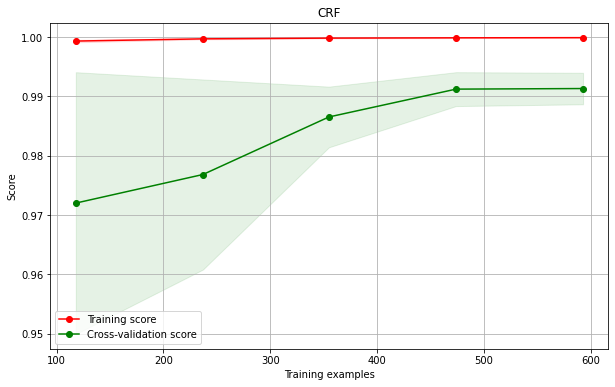

In [171]:
cv = KFold(n_splits=10, random_state=4, shuffle=True)
estimator = crf

plot_learning_curve(
    estimator, "CRF",
    X, 
    y, 
    cv=cv, 
    train_sizes=np.linspace(0.2, 1.0, 5)
)

#### Evaluation of model manually
Let's feed in our own sentence(s) and check how model perform in real world:

In [127]:
def sent2crf_feature(sent):
    words = list(nltk.tokenize.word_tokenize(sent))
    sent_crf_feat = [crf_features(words, i) for i in range(len(words))]
    return words, [sent_crf_feat]


def predict(sent):
    words, crf_feats = sent2crf_feature(sent)
    tags = crf.predict(crf_feats)[0]
    print(f"words={words}\ntags={tags}\n")
    colorful_words = []
    for w, t in zip(words, tags):
        if t == 'c':
            w = f"{color.BOLD}{color.BLUE}{w}{color.END}"
        elif t == 'a':
            w = f"{color.BOLD}{color.RED}{w}{color.END}"        
            
        colorful_words.append(w)
    
    print(" ".join(colorful_words))
    

In [128]:
my_sent="My car MAZDA MX-5 RF has bluetooth pairing issue."
predict(my_sent)

words=['My', 'car', 'MAZDA', 'MX-5', 'RF', 'has', 'bluetooth', 'pairing', 'issue', '.']
tags=['o', 'o', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o']

My car MAZDA MX-5 RF has bluetooth pairing issue .


In [136]:
my_sent="I setup a bluetooth connection to my car (Hyundai Sante Fe) and it works perfectly."
predict(my_sent)

words=['I', 'setup', 'a', 'bluetooth', 'connection', 'to', 'my', 'car', '(', 'Hyundai', 'Sante', 'Fe', ')', 'and', 'it', 'works', 'perfectly', '.']
tags=['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o']

I setup a bluetooth connection to my car ( Hyundai Sante Fe ) and it works perfectly .


In [173]:
my_sent="I can pair my phone with my car (Toyota RAV4) but neither profile (phone or audio) successfully connects and the pairing eventually fails."
predict(my_sent)

words=['I', 'can', 'pair', 'my', 'phone', 'with', 'my', 'car', '(', 'Toyota', 'RAV4', ')', 'but', 'neither', 'profile', '(', 'phone', 'or', 'audio', ')', 'successfully', 'connects', 'and', 'the', 'pairing', 'eventually', 'fails', '.']
tags=['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']

I can pair my phone with my car ( Toyota RAV4 ) but neither profile ( phone or audio ) successfully connects and the pairing eventually fails .


## <font color='darkblue'>Supplement</font>
* [All Car Brands](https://www.carlogos.org/car-brands/)
* [FAQ - How to handle unknown word in Gensim?](https://stackoverflow.com/questions/54709178/how-to-handle-words-that-are-not-in-word2vecs-vocab-optimally)